# Testing Source Extraction

Trying to take our single queried image and put it through SEP to get a segmentation map.

Primarily from the [SEP documentation](https://sep.readthedocs.io/en/stable/tutorial.html)

In [168]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as fits
from astropy.wcs import WCS
import sep

## Getting image

Loading up the image from decam. See query_images.ipynb for details.

In [169]:
import json
import requests
import pandas as pd

baseurl = "https://astroarchive.noirlab.edu/api"

url = f'{baseurl}/sia/vohdu?FORMAT=METADATA&format=json'

In [170]:
# simple image request of all the images within 1 degree of this ra and dec

# instrument: decam
instrument = 'decam'

# POS: position (ra,dec in degrees)
ra = 229.63841667
dec = 2.08102778   

# SIZE: angular size around position (degrees)
size = 1.0 

# limit: max number of records returned
limit = 10

# format: format of results (csv, xml, json)
format = 'json'

# image product type: we'll probably only be using 'image'
prod_type = 'image'
# image processing type: instacal / resampled / stacked / etc
image_type = 'resampled'

# this has a format of:
# vohdu?INPUT=value&INPUT=value
sia_request = f"{baseurl}/sia/vohdu?" + f"instrument={instrument}" +f"&POS={ra},{dec}" + f"&SIZE={size}" + \
    f"&prod_type={prod_type}" + f"&proc_type={image_type}" + f"&VERB=2" + f"&limit={limit}" + f"&format={format}"

# issue request and get data back in JSON format
sia_df = pd.DataFrame(requests.get(sia_request).json()[1:])

In [171]:
sia_df.columns

# index of a certain row from that (can be made from a condition) 
hdu_index = 2
# get the unique identifier for that row
file_id = sia_df['md5sum'][hdu_index]

single_image_url = f'{baseurl}/retrieve/{file_id}/?hdus={hdu_index}'
single_image_url = sia_df['url'][hdu_index]

(1990, 3989)

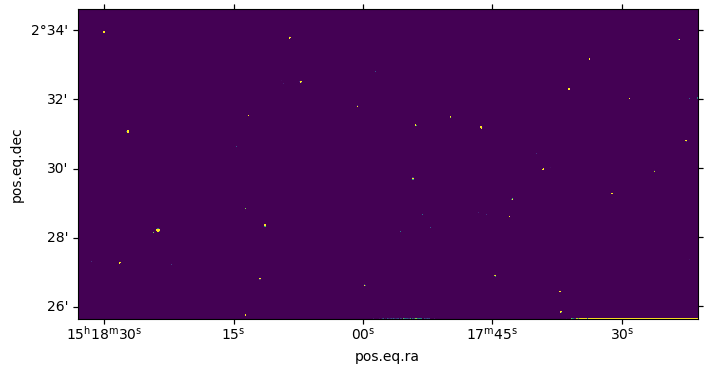

In [172]:
single_image = fits.open(single_image_url)

wcs = WCS(single_image[1].header)
zimage = single_image[1].data

fig = plt.figure(figsize=(8,16))
ax = plt.subplot(111, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
plt.imshow(zimage,vmin=90,vmax=200)
zimage.shape

In [173]:
## Finding the right zero point to know which threshold to use



In [181]:
objects = sep.extract(zimage, 200, segmentation_map=True)
seg_map = objects[1]

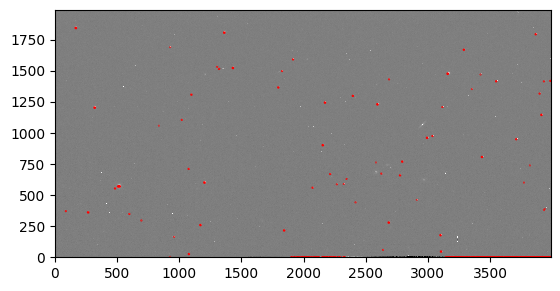

In [182]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(zimage), np.std(zimage)
im = ax.imshow(zimage, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects[0])):
    e = Ellipse(xy=(objects[0]['x'][i], objects[0]['y'][i]),
                width=6*objects[0]['a'][i],
                height=6*objects[0]['b'][i],
                angle=objects[0]['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

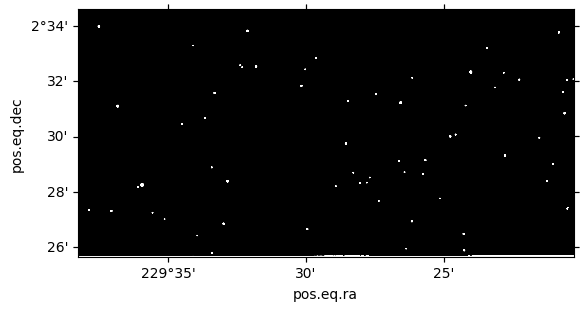

In [183]:
# rescale seg_map to the be in terms of arcsec (not pixels)

# get the pixel scale and coords from the header
pixscale = single_image[1].header['PIXSCALE']
ra = single_image[1].header['CRVAL1']
dec = single_image[1].header['CRVAL2']

fig = plt.figure();
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(seg_map, origin='lower', cmap='grey', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm')
lat.set_major_formatter('dd:mm')

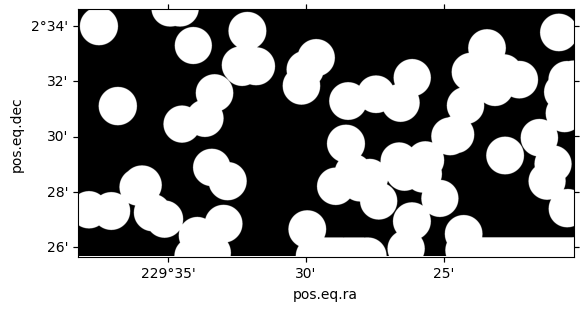

In [191]:
from scipy.ndimage import distance_transform_edt

# Calculate the distance transform of the seg_map
distance = distance_transform_edt(seg_map == 0,sampling=pixscale)

# Expand seg_map for exclusion zones
excl_map = np.copy(seg_map)
excl_map[distance <= 40] = 1

# Plot the updated seg_map
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(excl_map, origin='lower', cmap='gray', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm')
lat.set_major_formatter('dd:mm')
plt.show()

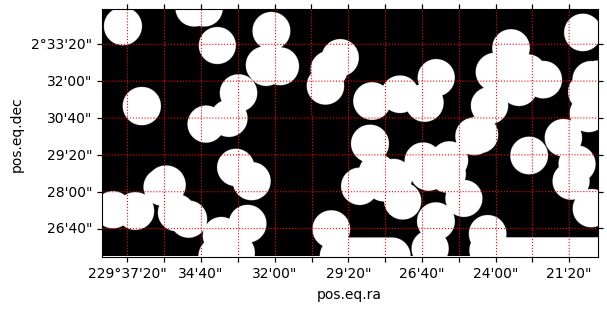

In [226]:
# Applying grid algorithm to the exclusion map
import astropy.units as u

fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(excl_map, origin='lower', cmap='gray', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(spacing=80*u.arcsec)
lat.set_ticks(spacing=80*u.arcsec)
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)
ax.coords.grid(True, color='red', ls='dotted')
plt.show()

In [230]:
grid_size = 80
height, width = excl_map.shape

# Calculate the number of grid squares in x and y directions
num_x_squares = int(width * pixscale / grid_size)
num_y_squares = int(height * pixscale / grid_size)

dark_regions = []

# Iterate through each grid square
for i in range(num_x_squares):
    for j in range(num_y_squares):
        # Calculate the coordinates of the current grid square
        x_start = int(i * grid_size / pixscale)
        x_end = int((i + 1) * grid_size / pixscale)
        y_start = int(j * grid_size / pixscale)
        y_end = int((j + 1) * grid_size / pixscale)
        
        # Check if there is any overlap with the exclusion map
        if np.all(excl_map[y_start:y_end, x_start:x_end] == 0):
            # Calculate the center of the grid square in pixel coordinates
            x_center = (x_start + x_end) / 2
            y_center = (y_start + y_end) / 2
            
            # Convert the center to RA/DEC coordinates
            ra_center, dec_center = wcs.wcs_pix2world(x_center, y_center, 1)
            
            # Append the center coordinates to the list
            dark_regions.append((float(ra_center), float(dec_center)))

dark_regions

[(229.62668228637006, 2.4830808591355966),
 (229.53772356204618, 2.5052939146792688),
 (229.51550972286057, 2.4830513884253955),
 (229.51550396582044, 2.5052872185512514),
 (229.4709773171146, 2.5497061945796955),
 (229.3820543447609, 2.4608056519508597)]